In [1]:
# LangChain supports many other chat models. Here, we're using Ollama
from langchain_community.chat_models import ChatOllama

from langchain_core.prompts import ChatPromptTemplate
from langchain.prompts import PromptTemplate

from langchain_core.output_parsers import StrOutputParser

In [3]:
# class to view the latest available supported parameters
llm = ChatOllama(model="llama3")

# Example
prompt = ChatPromptTemplate.from_template("Tell me briefly what you know about {topic}")
chain = prompt | llm | StrOutputParser()
print(chain.invoke({"topic": "Venice of time 1741"}))

Venice of Time, also known as "Venise du Temps" in French, is a baroque-style clock tower located in the town of La Chaux-de-Fonds, Switzerland. It was built in 1741 and stands at an impressive height of over 67 meters (220 feet).

The clock tower is known for its unique architecture, featuring a spiral staircase that wraps around the central clock mechanism. The tower also houses a small museum with exhibits on watchmaking and the history of La Chaux-de-Fonds.

What's fascinating about Venice of Time is its intricate design, which includes a series of concentric arches and columns that create a sense of depth and visual interest. It has become an iconic landmark in the town and a popular tourist destination.

Would you like to know more about its history, architecture, or any other aspect?


In [ ]:
import pandas as pd
spatial = [
    "What is the average rent price for properties located within 100 meters of a church compared to those further away in 1740?",
    "Which square has the highest density of nearby tenants in 1740?",
    "How does the rent price correlate with the distance from the nearest square in 1740?",
    "Where are the houses densely located in 1740?",
    "Are low-rent properties clustered in specific areas in 1740?",
    "How many people live within 50 meters of a church in 1740?",
    "On average, how much more expensive are houses near the squares compared to those further away in 1740?",
    "What is the correlation between the distance from the nearest church and the rent price in 1740?",
    "How many properties are located around square of San Marco in 1740?",
    "Are the properties located near San Marco more expensive than the properties located around other squares in 1740?",
    "On average how far people live from the squares in 1740?",
    "Are different families wide spread across the city or closely situated in certain neighborhoods in 1740?",
    "How many churches does each parish have in general in 1740?",
    "Is there a significant difference in rent prices for properties near churches versus squares in 1740?",
    "Are there any spatial clusters of high-rent properties in 1740?",
    "What is the name of the most densely populated square in 1740?",
    "How many buildings are there per parish on average in 1740?",
    "What is the spatial distribution of buildings with the highest and lowest rent prices in 1740?",
    "How does the density of buildings with multiple functions vary by parish in 1740?",
    "What is the average rent difference between the parishes with the highest and the lowest rent prices in 1740?"
]
functions = [
    "How do property functions change with increasing distance from the nearest square in 1740?",
    "Which squares are the centers of various activities based on surrounding property functions in 1740?",
    "Are residential properties more closely located to the squares than the commercial properties in 1740?",
    "How closely are workshops located to the squares in 1740?",
    "Are properties with multiple functions more expensive than the ones with a single function in 1740?",
    "What are the most common combinations of property functions in the dataset in 1740?",
    "What is the correlation between property functions and their proximity to the churches in 1740?",
    "Which squares are surrounded by the most diverse set of property functions in 1740?",
    "Is there a correlation between the number of building functions and the rent price in 1740?",
    "Which squares are the commercial hubs in 1740?"
]
personal = [
    "Which family owns the most number of properties and are they wide spread across the city, or closely located in 1740?",
    "Is there any correlation between the family name and the profession in 1740?",
    "Are different families wide spread across the city or closely situated in certain neighborhoods in 1740?",
    "Are there any spatial clusters of buildings owned by the same family in 1740?",
    "How many lawyers are there in Venice in 1740?",
    "In which parish do lawyers own the most number of properties in 1740?",
    "Is there a significant difference in rent prices based on the profession of the property owner in 1740?",
    "What is the distribution of building functions among properties owned by the same family in 1740?",
    "Are there any notable family alliances or rivalries suggested by the spatial distribution of properties in 1740?",
    "Do certain professions tend to own properties with specific functions in 1740?"
]
comparison_geolocation = [
    "How many families were relocated by more than 1km between 1740 and 1808?",
    "What is the average distance moved by families who owned properties in both 1740 and 1808?",
    "Are there any specific areas in Venice where families tended to relocate to more frequently between 1740 and 1808?",
    "Did certain professions exhibit higher rates of relocation compared to others between 1740 and 1808?",
    "Is there a correlation between the rent price in 1740 and the distance moved by families by 1808?",
    "Are there any notable patterns in the professions of families that remained in Venice between 1740 and 1808?",
    "How many families expanded their property holdings between 1740 and 1808?",
    "How many families relocated their properties closer to or further from squares between 1740 and 1808?",
    "What is the average distance between family properties and the nearest church or square in 1740 compared to 1808?",
    "How did the density of family properties around central squares change between 1740 and 1808?"
]
comparison_ownership = [
    "How many families present in Venice in 1740 still exist in the 1808?",
    "Did any families significantly increase the number of properties they owned from 1740 to 1808?",
    "How did the functions of buildings change for families who owned properties in both 1740 and 1808? Did they shift from residential to commercial use, or vice versa?",
    "How many families retained the same profession (as indicated by building functions) across the two time periods?",
    "Can we identify any patterns of inheritance or succession among families who maintained property ownership?",
    "How many new families appear in Venice in 1808 that were not present in 1740?",
    "Is there any decrease in the number of properties held by a family on average between 1740 and 1808?",
    "Are there any families who moved closer to or further away from the churches in general between 1740 and 1808?",
    "How many families who owned properties in both 1740 and 1808 changed the type of buildings they owned, such as from residential to commercial?",
    "Did any families transition from being tenants in 1740 to property owners in 1808?"
]
comparison_functions = [
    "Have the squares for commercial hubs changed between 1740 and 1808?",
    "Where are the houses densely located in both 1740 and 1808, and how has this changed?",
    "Are smaller buildings, in terms of area, specifically clustered in certain areas in 1808 compared to the locations of low-rent properties in 1740?",
    "How many buildings are located within 50 meters of a church in 1808 compared to 1740?",
    "On average, how much larger are the buildings near the squares in 1808 compared to those further away, and how does this compare to rent price differences in 1740?",
    "How many properties are located around the square of San Marco in 1808 compared to 1740?",
    "Are there any spatial clusters of large buildings in 1808 compared to high-rent properties in 1740?",
    "Are different families widely spread across the city or closely situated in certain neighborhoods in both 1740 and 1808?",
    "What are the names of the most densely populated squares in both periods between 1740 and 1808?",
    "What type of buildings have been moved further away from or closer to the churches between 1740 and 1808?"
]
questions = pd.DataFrame({
    'question':spatial + functions + personal + comparison_geolocation + comparison_ownership + comparison_functions,
    'type':len(spatial) * ['spatial'] + len(functions) * ['functions'] + len(personal) * ['personal'] + len(comparison_geolocation) * ['comparison_geolocation'] + len(comparison_ownership) * ['comparison_ownership'] + len(comparison_functions) * ['comparison_functions']
})

# Entity name detector

In [131]:
# Entity name detector
import re
import ast

def extract_landmark_info(input_string):
    # Use regular expression to find the pattern
    pattern = r"\[\(.*?\)\]"
    matches = re.findall(pattern, input_string)
    
    # Convert the string found to a list of tuples using ast.literal_eval for safety
    result = ast.literal_eval(matches[0]) if matches else []
    return result
    
entity_detector_prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
You are a highly skilled data analyst specializing in historical data analysis. You are working with two datasets, one detailing buildings in Venice from 1740 and the other listing landmarks such as churches and squares in Venice. Your task is to identify specific entity names mentioned in a question that should be matched with values in columns of these datasets and determine if the entity name requires translation into Italian. The datasets are as follows:

1. Buildings Dataset (buildings.csv) columns:
- Owner_First_Name
- Owner_Family_Name
- Owner_Profession -- given in Italian
- Tenant_Name
- Building_Functions -- a list of the functions the building served as. Given in italian.
- Rent_Price -- numerical value that refers to Italian ducats.
- Location
- Parish
- Building_Functions_Count -- same as length of Building_Functions
- Longitude
- Latitude

2. Landmarks Dataset (landmarks.csv) columns:
- Landmark_Name
- Landmark_Type -- either "square" or "church"
- Longitude
- Latitude
<|eot_id|><|start_header_id|>user<|end_header_id|>

Given a question, you need to detect the entity names that should be matched with values in the columns of one of the datasets. Focus on identifying entity names that correspond directly to values in the datasets, not the column names themselves unless explicitly stated. And determine if the detected entity name requires translation into Italian.
Generally, professions and building functions require translation into Italian if the question states them in English. 

For example:
If the question is "How many people live in Venice?", output an empty list because no specific entity name needs to be matched with dataset values.
If the question is "Which squares are surrounded by the most diverse set of building functions?", output [("squares", "Landmark_Type", 2, False)], since "squares" corresponds to the "Landmark_Type" column in the landmarks dataset (2nd dataset), and "squares" does not require any translation as it is given in the dataset in English.
Output the list of detected entity names with their corresponding column names and the dataset in the format [(entity_name, column_name, dataset_number, needs_translation)].

Examples:

Question: "How many buildings are located near Santa Maria della Salute?"
Output: [("Santa Maria della Salute", "Landmark_Name", 2, False)]

Question: "What is the average rent price of buildings in San Polo?"
Output: [("San Polo", "Parish", 1, False)]

Question: "Do doctors own the most number of properties in Dorsoduro parish?"
Output: [("doctors", "Owner_Profession", 1, True), ("Dorsoduro", "Parish", 1, False)]

Question: "Are low-rent properties clustered in specific areas?"
Output: []

Please identify the relevant entity names and their corresponding column names for the following question and return only the output in the format [(entity_name, column_name, dataset_number, needs_translation)].
Question:{question}
Output: <|eot_id|>
<|start_header_id|>assistant<|end_header_id|>
""",
    input_variables=["question"],
)

entity_detector = entity_detector_prompt | llm | StrOutputParser()

# question = """How many people live around the square of San Marco?"""

# result = entity_detector.invoke({"question": question})
# print(result)

# clean_result = extract_landmark_info(result)
# print(clean_result)

print(extract_landmark_info(entity_detector.invoke({"question":questions['question'][0]}).split("<|start_header_id|>assistant<|end_header_id|>")[1]))

# Find matches

## Translation

In [7]:
import deepl
auth_key = "ac62708c-f129-496a-a868-76d0f9d2e4d9:fx"
translator = deepl.Translator(auth_key)

def translate_text(text: str, source_lang: str = "EN", target_lang: str = "IT") -> str:
    """
    Translates text into the target language.
    """
        
    result = translator.translate_text(text, source_lang=source_lang, target_lang=target_lang)
    print(result.text)

translate_text('workshop')

officina


## Matching

In [8]:
# Exact search

def exact_search(query, strings):
    """
    Perform an exact search on a list of strings and return values with a similarity score higher than threshold.
    """
    if query in strings:
        return [query]
    else:
        return []
        
# Example usage
strings = ["casa", "bottrghetta", "bottega", "bottega olio", "magazen sotto casa"]

result = exact_search("officina", strings)
print(result)

result = exact_search("bottega", strings)
print(result)

result = exact_search("bottegha", strings)
print(result)

[]
['bottega']
[]


In [9]:
# Fuzzy search

from rapidfuzz import fuzz

def fuzzy_search(query, strings, threshold=70):
    """
    Perform a fuzzy similarity search on a list of strings and return values with a similarity score higher than threshold.
    Relies on Levenshtein Distance: Measures the minimum number of single-character edits (insertions, deletions, or substitutions) required to change one word into the other.
    """
    return [string for string in strings if fuzz.ratio(string, query) > threshold]

# Example usage
strings = ["casa", "bottrghetta", "bottega", "bottega olio", "magazen sotto casa"]

result = fuzzy_search("officina", strings)
print(result)

result = fuzzy_search("bottega", strings)
print(result)

result = fuzzy_search("bottegha", strings)
print(result)

[]
['bottega', 'bottega olio']
['bottrghetta', 'bottega']


In [11]:
# Similarity search

from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

def similarity_search(query, strings, threshold=0.7):
    """
    Perform a similarity search on a list of strings and return values with a similarity score higher than threshold.
    """
    query_embedding = model.encode(query, convert_to_tensor=True)
    strings_embeddings = model.encode(strings, convert_to_tensor=True)
    
    similarities = util.pytorch_cos_sim(query_embedding, strings_embeddings)[0]
    result = [strings[i] for i in range(len(strings)) if similarities[i] > threshold]
    
    return result

# Example usage
strings = ["casa", "bottrghetta", "bottega", "bottega olio", "magazen sotto casa"]

result = similarity_search("officina", strings)
print(result)

result = similarity_search("bottega", strings)
print(result)

result = similarity_search("bottegha", strings)
print(result)

['bottega']
['bottega', 'bottega olio']
['casa', 'bottega', 'bottega olio']


In [53]:
### Convert it into a LangGraph Node ###
import pandas as pd

print(clean_result)

datasets = {1: "data/buildings.csv", 2: "data/landmarks.csv"}
entities_matches = {}

for entity in clean_result:
    # get entity name
    entity_name = entity[0].lower()

    # translate the entity name if needed
    entity_name_translation = None
    if entity[3]:
        entity_name_translation = translate_text(entity_name)

    # get the column values from the dataset
    dataset = pd.read_csv(datasets[entity[2]])
    dataset = dataset[dataset[entity[1]].notna()]
    column_values = dataset[entity[1]].unique()

    # get exact matching
    matches = exact_search(entity_name, column_values)

    # fuzzy search
    if len(matches) == 0:
        matches = fuzzy_search(entity_name, column_values)

    # similarity search
    threshold = 0.9
    while len(matches) == 0 and threshold >= 0.5:
        matches = similarity_search(entity_name, column_values, threshold=threshold)
        threshold -= 0.05

    # skip this entity if not matches are found with at least 50% of similarity
    if len(matches) == 0:
        break

    # set the entity name
    entities_matches[entity_name] = {}
    entities_matches[entity_name]['dataset'] = datasets[entity[2]]
    entities_matches[entity_name]['column'] = entity[1]
    entities_matches[entity_name]['matches'] = matches
    if entity_name_translation is not None:
        entities_matches[entity_name]['italian_translation'] = entity_name_translation

print(entities_matches)

[('San Marco', 'Landmark_Name', 2, False)]
{'san marco': {'dataset': 'data/landmarks.csv', 'column': 'Landmark_Name', 'matches': ['piazza san marco']}}


# Planner

In [132]:
# Planner
planner_prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
You are a highly skilled data analyst specializing in historical data analysis. You are working with two datasets, one detailing buildings in Venice from 1740 and the other listing landmarks such as churches and squares in Venice. Your task is to write a step-by-step plan in natural language to answer the given question using the provided information and datasets. The datasets are as follows:

1. Buildings Dataset (buildings.csv) columns:
- Owner_First_Name
- Owner_Family_Name
- Owner_Profession -- given in Italian
- Tenant_Name
- Building_Functions -- a list of the functions the building served as. Given in italian.
- Rent_Price -- numerical value that refers to Italian ducats.
- Location
- Parish
- Building_Functions_Count -- same as length of Building_Functions
- Longitude
- Latitude

2. Landmarks Dataset (landmarks.csv) columns:
- Landmark_Name
- Landmark_Type -- either "square" or "church"
- Longitude
- Latitude
<|eot_id|><|start_header_id|>user<|end_header_id|>
You are given a question and the extracted information of each entity found in the question that contains the dataset and the column that the entity matches to, and the corresponding exact matches that is given in the dataset.
Provide a step-by-step plan only in a natural language that can be followed to write a Python code that answers the question using the provided datasets.
Be as clear and explicit as possible in your instructions. Assume the datasets are in CSV format and the necessary libraries for data analysis in Python are available (e.g., pandas, numpy).

Question:
{question}

Entity Matches:
{entities_matches}

Step by Step Plan:
<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>
""",
    input_variables=["question", "entities_matches"],
)

planner = planner_prompt | llm | StrOutputParser()

# print(question)
# print(entities_matches)
# print("-"*30)

# plan = planner.invoke({"question": question, "entities_matches": entities_matches})
# print(plan)

# Coder

In [133]:
# Coder
import re

def extract_python_code(text):
    # Define a regular expression pattern to match Python code blocks
    pattern = r'```python(.*?)```|```\s*(.*?)```|```Python(.*?)```'
    
    # Find all matches in the text
    matches = re.findall(pattern, text, re.DOTALL)
    
    # Extract the code from matches
    code_blocks = [match[0] if match[0] else match[1] for match in matches]
    
    # Join all code blocks into a single string with new lines between blocks
    code = '\n\n'.join(code_blocks).strip()
    
    return code
    
coder_prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
You are a highly skilled Python developer with expertise in data analysis. You are provided with a question, extracted entity matches, and a detailed plan to write Python code that answers the question using two datasets. Your task is to generate the Python code based on the provided detailed plan. The datasets are as follows:

1. Buildings Dataset (buildings.csv) columns:
- Owner_First_Name
- Owner_Family_Name
- Owner_Profession -- given in Italian
- Tenant_Name
- Building_Functions -- a list of the functions the building served as. Given in italian.
- Rent_Price -- numerical value that refers to Italian ducats.
- Location
- Parish
- Building_Functions_Count -- same as length of Building_Functions
- Longitude
- Latitude

2. Landmarks Dataset (landmarks.csv) columns:
- Landmark_Name
- Landmark_Type -- either "square" or "church"
- Longitude
- Latitude
<|eot_id|><|start_header_id|>user<|end_header_id|>
Generate a Python code that follows the detailed plan and answers the given question using the provided datasets.
Use the necessary libraries for data analysis in Python (e.g., pandas, numpy). The code should be well-structured, complete and intended to be executed as a whole.

Question:
{question}

Entity Matches:
{entities_matches}

Step by Step Plan:
{plan}

Python Code:
<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>
""",
    input_variables=["question", "entities_matches", "plan"],
)

coder = coder_prompt | llm | StrOutputParser()

# print(question)
# print(entities_matches)
# print("-"*50)

# code = coder.invoke({"question": question, "entities_matches": entities_matches, "plan": plan})
# print(code)
# print("-"*50)

# code_clean = extract_python_code(code)
# print(code_clean)

# Debugger

In [134]:
# Debugger   
prompt_debug = """<|begin_of_text|><|start_header_id|>system<|end_header_id|>
You are a highly skilled Python developer with expertise in data analysis. You are provided with a question, extracted entity matches, a detailed plan to write Python code that answers the question using 3 datasets, the incorrect python code, and the corresponding error message. Your task is to correct and rewrite the Python code based on the provided error message and the detailed plan. The datasets are as follows:

1. 1740 Buildings Dataset (data/buildings_1740.csv) columns:
- Owner_First_Name
- Owner_Family_Name
- Owner_Profession -- given in Italian
- Tenant_Name
- Building_Functions -- a list of the functions the building served as. Given in italian.
- Rent_Price -- numerical value that refers to Italian ducats.
- Location
- Parish
- Building_Functions_Count -- same as length of Building_Functions
- Longitude
- Latitude

2. 1808 Buildings Dataset (data/buildings_1808.csv) columns:
- Owner_First_Name
- Owner_Family_Name
- Building_Functions -- a list of the functions the building served as. Given in italian.
- Building_Functions_Count -- same as length of Building_Functions
- Building_Area -- in meters square.
- Location
- District
- Longitude
- Latitude

3. Landmarks Dataset (data/landmarks.csv) columns:
- Landmark_Name
- Landmark_Type -- either "square" or "church"
- Longitude
- Latitude
<|eot_id|><|start_header_id|>user<|end_header_id|>
Correct the error in the following Python code that follows the detailed plan and answers the given question using the provided datasets.
Use the necessary libraries for data analysis in Python (e.g., pandas, numpy). The code should be well-structured, complete and intended to be executed as a whole.

Question:
{question}

Entity Matches:
{entities_matches}

Step by Step Plan:
{plan}

Python Code:
{code}

Error Message:
{error_message}

Corrected Python Code:
<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>"""

debugger_prompt = PromptTemplate(
    template=prompt_debug,
    input_variables=["question", "entities_matches", "plan", "code", "error_message"],
)

debugger = debugger_prompt | llm | StrOutputParser()
# code = debugger.invoke({"question": question, "entities_matches": entities_matches, "plan": plan})
# code_clean = extract_python_code(code)

# Building the Graph (Putting it all together)

In [135]:
from typing_extensions import TypedDict
from typing import List

### State
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        entities: entities found in the question
        entities_matches: matche valus of the entities
        plan: analysis plan
        code: code
        error_message: error message
        error: flag for error
        num_steps: number of steps
        output: output of the code
    """
    question : str
    entities: List[tuple]
    entities_matches : dict
    plan : str
    code : str
    error_message: str
    error : bool
    num_steps : int
    output: str

## Nodes

In [136]:
def detect_entities(state):
    """detect the entity names in the question"""
    question = state['question']

    # find the entity names
    entities = entity_detector.invoke({"question": question})

    # extract the list of entities
    entities_extracted = extract_landmark_info(entities)

    print("--------------- Detected Entities ---------------")
    print(entities_extracted, end='\n\n')

    return {"entities": entities_extracted}

In [137]:
def find_matches(state):
    """find the matches of the entities from the datasets"""
    entities = state['entities']

    # define dataset mapping
    datasets = {1: "data/buildings.csv", 2: "data/landmarks.csv"}

    # initialize entities matches
    entities_matches = {}

    for entity in entities:
        # get entity name
        entity_name = entity[0].lower()
    
        # translate the entity name if needed
        entity_name_translation = None
        if entity[3]:
            entity_name_translation = translate_text(entity_name)
    
        # get the column values from the dataset
        dataset = pd.read_csv(datasets[entity[2]])
        dataset = dataset[dataset[entity[1]].notna()]
        column_values = dataset[entity[1]].unique()
    
        # get exact matching
        matches = exact_search(entity_name, column_values)
    
        # fuzzy search
        if len(matches) == 0:
            matches = fuzzy_search(entity_name, column_values)
    
        # similarity search
        threshold = 0.9
        while len(matches) == 0 and threshold >= 0.5:
            matches = similarity_search(entity_name, column_values, threshold=threshold)
            threshold -= 0.05
    
        # skip this entity if not matches are found with at least 50% of similarity
        if len(matches) == 0:
            break
    
        # set the entity name
        entities_matches[entity_name] = {}
        entities_matches[entity_name]['dataset'] = datasets[entity[2]]
        entities_matches[entity_name]['column'] = entity[1]
        entities_matches[entity_name]['matches'] = matches
        if entity_name_translation is not None:
            entities_matches[entity_name]['italian_translation'] = entity_name_translation

    print("--------------- Matched Entities ---------------")
    print(entities_matches, end='\n\n')

    return {"entities_matches": entities_matches}

In [138]:
def create_plan(state):
    """creates a plan to answer the question"""
    question = state['question']
    entities_matches = state['entities_matches']

    # create the plan
    plan = planner.invoke({"question": question, "entities_matches": entities_matches})

    print("--------------- Plan ---------------")
    print(plan, end='\n\n')

    return {"plan": plan}

In [139]:
def write_code(state):
    """writes / debugs a code following the given plan / error message"""
    question = state['question']
    entities_matches = state['entities_matches']
    plan = state['plan']
    code = state['code']
    error_message = state['error_message']
    error = state['error']
    num_steps = state['num_steps']

    # Generate or Debug the code
    if error:
        code = debugger.invoke({"question": question, "entities_matches": entities_matches, "plan": plan, "code": code, "error_message": error_message})
    else:
        code = coder.invoke({"question": question, "entities_matches": entities_matches, "plan": plan})

    # extract the code block
    code_block = extract_python_code(code)
    
    print("--------------- Code ---------------")
    print(code_block, end='\n\n')

    num_steps += 1
    
    return {"code": code_block, "num_steps": num_steps}

In [152]:
import traceback

def execute(state):
    """executes the given code"""
    code = state['code']

    # execute the code
    try:
        print("--------------- Output ---------------")
        output = exec(code)
    except Exception:
        error_message = traceback.format_exc()

        print("--------------- Error ---------------")
        print(error_message, end='\n\n')

        return {"error_message": error_message, "error": True}

    return {"output": output, "error": False}

## Edges

In [153]:
def check_entities(state):
    """decides whether to go to planner or entity matcher"""
    entities = state['entities']

    if len(entities) == 0:
        return "create_plan"
    else:
        return "find_matches"

max_num_steps = 10

def check_output(state: GraphState):
    """determines whether to finish."""
    error = state["error"]
    num_steps = state["num_steps"]

    if error == False or num_steps == max_num_steps:
        return "end"
    else:
        return "degub"

In [154]:
from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes 
workflow.add_node("detect_entities", detect_entities)
workflow.add_node("find_matches", find_matches)
workflow.add_node("create_plan", create_plan)
workflow.add_node("write_code", write_code)
workflow.add_node("execute", execute)

# Build graph
workflow.set_entry_point("detect_entities")
workflow.add_conditional_edges(
    "detect_entities",
    check_entities,
    {
        "create_plan": "create_plan",
        "find_matches": "find_matches",
    },
)
workflow.add_edge("find_matches", "create_plan")
workflow.add_edge("create_plan", "write_code")
workflow.add_edge("write_code", "execute")
workflow.add_conditional_edges(
    "execute",
    check_output,
    {
        "degub": "write_code",
        "end": END,
    },
)

app = workflow.compile()

## Demo

#### Graph

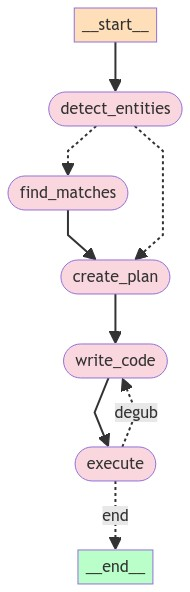

In [155]:
from IPython.display import Image, display

# Visualize the graph
display(Image(app.get_graph().draw_mermaid_png()))

#### Demo

In [157]:
question = "How many people live around the square of San Marco?"
app.invoke({"question": question, "error": False, "num_steps": 0})

--------------- Detected Entities ---------------
[('San Marco', 'Landmark_Name', 2, False)]

--------------- Matched Entities ---------------
{'san marco': {'dataset': 'data/landmarks.csv', 'column': 'Landmark_Name', 'matches': ['piazza san marco']}}

--------------- Plan ---------------
Here is a step-by-step plan to answer the question:

**Step 1: Load the datasets**
Load the "buildings.csv" and "landmarks.csv" files into Python using pandas. Name the dataframes as "buildings_df" and "landmarks_df".

```
import pandas as pd
buildings_df = pd.read_csv('buildings.csv')
landmarks_df = pd.read_csv('landmarks.csv')
```

**Step 2: Filter the landmarks dataframe**
Filter the "landmarks_df" to only include rows where the "Landmark_Name" matches one of the exact matches provided ("piazza san marco"). Use pandas' built-in filtering function, `.loc[]`, or `.query()`.

```
san_marco_df = landmarks_df.loc[landmarks_df['Landmark_Name'].isin(['piazza san marco']), :]
# or
san_marco_df = landmarks_

{'question': 'How many people live around the square of San Marco?',
 'entities': [('San Marco', 'Landmark_Name', 2, False)],
 'entities_matches': {'san marco': {'dataset': 'data/landmarks.csv',
   'column': 'Landmark_Name',
   'matches': ['piazza san marco']}},
 'plan': 'Here is a step-by-step plan to answer the question:\n\n**Step 1: Load the datasets**\nLoad the "buildings.csv" and "landmarks.csv" files into Python using pandas. Name the dataframes as "buildings_df" and "landmarks_df".\n\n```\nimport pandas as pd\nbuildings_df = pd.read_csv(\'buildings.csv\')\nlandmarks_df = pd.read_csv(\'landmarks.csv\')\n```\n\n**Step 2: Filter the landmarks dataframe**\nFilter the "landmarks_df" to only include rows where the "Landmark_Name" matches one of the exact matches provided ("piazza san marco"). Use pandas\' built-in filtering function, `.loc[]`, or `.query()`.\n\n```\nsan_marco_df = landmarks_df.loc[landmarks_df[\'Landmark_Name\'].isin([\'piazza san marco\']), :]\n# or\nsan_marco_df = l

Above, the final output is "Number of people living around San Marco: 176"